# AI Search vs RL — Final Notebook (v3)

**Grid:** 8×8 — BFS, DFS, A*, Tabular Q-Learning, PPO (reward-shaped + stabilized)

All outputs (models, logs, GIFs) are saved to `/content/drive/MyDrive/AI_Assignment/` when run in Colab.

Generated: 2025-10-14

**Run this notebook end-to-end in Colab.** First cell should mount Google Drive to save outputs.

In [1]:
# Optional: install dependencies if needed (uncomment to run)
!pip install -q numpy==1.26.4 pandas==2.2.2 gymnasium==0.29.1 stable-baselines3[extra]==2.4.0 imageio matplotlib seaborn tqdm
!pip install --upgrade --force-reinstall numpy pandas matplotlib imageio seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 11.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 

In [2]:
import os, random, time, math
from collections import deque, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import imageio
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

# Try import SB3
try:
    import gymnasium as gym
    from gymnasium import spaces
    from stable_baselines3 import PPO
    from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
    from stable_baselines3.common.monitor import Monitor
    from stable_baselines3.common.callbacks import EvalCallback
    from stable_baselines3.common.evaluation import evaluate_policy
    SB3_AVAILABLE = True
    print('stable-baselines3 & gymnasium available')
except Exception as e:
    SB3_AVAILABLE = False
    print('stable-baselines3 or gymnasium not available:', e)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Results directory (Drive path)
RESULTS_DIR = '/content/drive/MyDrive/AI_Assignment'
os.makedirs(RESULTS_DIR, exist_ok=True)
print('Results saved to', RESULTS_DIR)


stable-baselines3 & gymnasium available
Results saved to /content/drive/MyDrive/AI_Assignment


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class EnergyGridEnv(gym.Env):
    metadata = {'render_modes': ['human', 'rgb_array']}

    def __init__(self, size=8, max_energy=25, seed=None,
                 step_penalty=-0.5, progress_reward=1.0,
                 goal_reward=50.0, obstacle_density=0.04):
        super().__init__()
        self.size = size
        self.max_energy = max_energy
        self.step_penalty = step_penalty
        self.progress_reward = progress_reward
        self.goal_reward = goal_reward
        self.obstacle_density = obstacle_density
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(
            low=-1.0, high=1.0,
            shape=(self.size * self.size + 1,),
            dtype=np.float32
        )
        self.place_random_obstacles()
        self.reset()

    def place_random_obstacles(self):
        cells = [(i, j) for i in range(self.size) for j in range(self.size)]
        self.rng.shuffle(cells)
        n = int(len(cells) * self.obstacle_density)
        self.obstacles = set(cells[:n])

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        while True:
            self.agent = (int(self.rng.integers(0, self.size)), int(self.rng.integers(0, self.size)))
            self.goal = (int(self.rng.integers(0, self.size)), int(self.rng.integers(0, self.size)))
            if self.agent != self.goal and self.agent not in self.obstacles and self.goal not in self.obstacles:
                break

        self.energy = self.max_energy
        self.steps = 0
        self.done = False
        self.prev_dist = self._manhattan(self.agent, self.goal)
        return self._get_obs(), {}

    def _manhattan(self, a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def _get_obs(self):
        grid = np.zeros((self.size, self.size), dtype=np.float32)
        for (i, j) in self.obstacles:
            grid[i, j] = -1.0
        grid[self.agent] = 0.5
        grid[self.goal] = 1.0
        flat = grid.flatten().astype(np.float32)
        obs = np.concatenate([flat, np.array([self.energy / self.max_energy], dtype=np.float32)])
        return obs

    def step(self, action):
        if self.done:
            return self._get_obs(), 0.0, True, False, {}

        self.steps += 1
        ax, ay = self.agent
        if action == 0 and ax > 0: ax -= 1
        elif action == 1 and ax < self.size - 1: ax += 1
        elif action == 2 and ay > 0: ay -= 1
        elif action == 3 and ay < self.size - 1: ay += 1

        new_pos = (ax, ay)
        collision = new_pos in self.obstacles
        if collision:
            new_pos = self.agent
        self.agent = new_pos
        self.energy -= 1

        dist = self._manhattan(self.agent, self.goal)
        progress = self.prev_dist - dist
        reward = self.step_penalty
        if progress > 0:
            reward += self.progress_reward * progress
        if collision:
            reward -= 2.0
        success = False
        if dist == 0:
            reward += self.goal_reward
            self.done = True
            success = True
        if self.energy <= 0 or self.steps >= (self.size * self.size * 4):
            self.done = True
            reward -= 10.0
        self.prev_dist = dist

        return self._get_obs(), reward, self.done, False, {'success': success}

    def render(self, mode='rgb_array'):
        """Always return an RGB image; supports human/rgb_array modes."""
        grid = np.full((self.size, self.size), '.', dtype=object)
        for (i, j) in self.obstacles:
            grid[i, j] = '#'
        ax, ay = self.agent
        gx, gy = self.goal
        grid[gx, gy] = 'G'
        grid[ax, ay] = 'A'

        img = np.ones((self.size, self.size, 3), dtype=np.uint8) * 255
        for i in range(self.size):
            for j in range(self.size):
                if grid[i, j] == '#':
                    img[i, j] = [150, 150, 150]
                elif grid[i, j] == 'A':
                    img[i, j] = [30, 144, 255]
                elif grid[i, j] == 'G':
                    img[i, j] = [50, 205, 50]
        img = np.kron(img, np.ones((40, 40, 1), dtype=np.uint8))
        return img


In [4]:
from collections import deque
import heapq, time

def neighbors(cell, size, obstacles=set()):
    i,j = cell
    for di,dj in [(-1,0),(1,0),(0,-1),(0,1)]:
        ni, nj = i+di, j+dj
        if 0 <= ni < size and 0 <= nj < size and (ni,nj) not in obstacles:
            yield (ni, nj)

def bfs_search(start, goal, size, obstacles=set()):
    t0 = time.time(); frontier = deque([start]); parent={start:None}; nodes=0
    while frontier:
        node = frontier.popleft(); nodes+=1
        if node==goal:
            path=[]; cur=node
            while cur is not None:
                path.append(cur); cur=parent[cur]
            return list(reversed(path)), nodes, time.time()-t0
        for n in neighbors(node,size,obstacles):
            if n not in parent:
                parent[n]=node; frontier.append(n)
    return None,nodes,time.time()-t0

def dfs_search(start, goal, size, obstacles=set()):
    t0 = time.time(); stack=[start]; parent={start:None}; nodes=0
    while stack:
        node = stack.pop(); nodes+=1
        if node==goal:
            path=[]; cur=node
            while cur is not None:
                path.append(cur); cur=parent[cur]
            return list(reversed(path)), nodes, time.time()-t0
        for n in neighbors(node,size,obstacles):
            if n not in parent:
                parent[n]=node; stack.append(n)
    return None,nodes,time.time()-t0

def astar_search(start, goal, size, obstacles=set(), heur=lambda a,b: abs(a[0]-b[0])+abs(a[1]-b[1])):
    t0=time.time(); frontier=[]; heapq.heappush(frontier,(heur(start,goal), start)); parent={start:None}; gscore={start:0}; nodes=0
    while frontier:
        f,node = heapq.heappop(frontier); nodes+=1
        if node==goal:
            path=[]; cur=node
            while cur is not None:
                path.append(cur); cur=parent[cur]
            return list(reversed(path)), nodes, time.time()-t0
        for n in neighbors(node,size,obstacles):
            tentative = gscore[node] + 1
            if n not in gscore or tentative < gscore[n]:
                gscore[n]=tentative
                heapq.heappush(frontier, (tentative + heur(n,goal), n))
                parent[n]=node
    return None,nodes,time.time()-t0


In [5]:
env = EnergyGridEnv(size=8, max_energy=20, seed=42, obstacle_density=0.06)
obs,_ = env.reset()
print('Agent:', env.agent, 'Goal:', env.goal)
env.render()
path_bfs, nodes_bfs, t_bfs = bfs_search(env.agent, env.goal, env.size, env.obstacles)
print('BFS ->', len(path_bfs) if path_bfs else None, 'nodes', nodes_bfs, 'time', t_bfs)
path_dfs, nodes_dfs, t_dfs = dfs_search(env.agent, env.goal, env.size, env.obstacles)
print('DFS ->', len(path_dfs) if path_dfs else None, 'nodes', nodes_dfs, 'time', t_dfs)
path_ast, nodes_ast, t_ast = astar_search(env.agent, env.goal, env.size, env.obstacles)
print('A* ->', len(path_ast) if path_ast else None, 'nodes', nodes_ast, 'time', t_ast)


Agent: (5, 0) Goal: (2, 6)
BFS -> 10 nodes 52 time 0.00011420249938964844
DFS -> 28 nodes 32 time 4.291534423828125e-05
A* -> 10 nodes 12 time 4.506111145019531e-05


Q-Learning avg last 50: 34.21


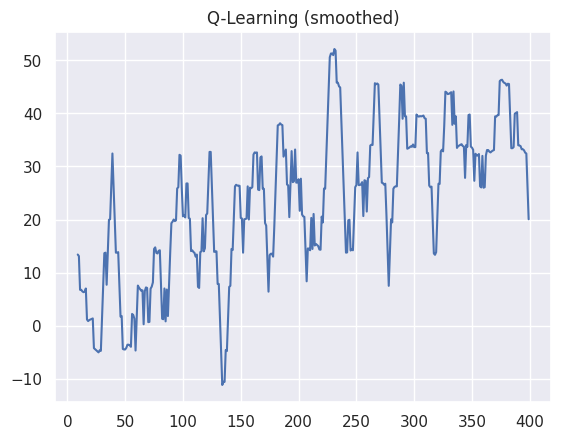

In [6]:
class TabularQLearner:
    def __init__(self, env, alpha=0.6, gamma=0.98, eps=0.12):
        self.env = env; self.alpha=alpha; self.gamma=gamma; self.eps=eps
        self.q = defaultdict(lambda: np.zeros(self.env.action_space.n))
    def _encode(self, obs):
        grid = obs[:-1].reshape(self.env.size, self.env.size)
        agent_idx = np.argwhere(grid==0.5)
        goal_idx = np.argwhere(grid==1.0)
        if agent_idx.size==0: ax,ay = self.env.agent
        else: ax,ay = int(agent_idx[0][0]), int(agent_idx[0][1])
        if goal_idx.size==0: gx,gy = self.env.goal
        else: gx,gy = int(goal_idx[0][0]), int(goal_idx[0][1])
        return (ax,ay,gx,gy)
    def choose(self, s):
        if random.random() < self.eps: return random.randrange(self.env.action_space.n)
        return int(np.argmax(self.q[s]))
    def train_episode(self, max_steps=200):
        obs,_ = self.env.reset(); s=self._encode(obs); total=0.0
        for _ in range(max_steps):
            a=self.choose(s)
            obs2,r,done,_,info = self.env.step(a)
            s2=self._encode(obs2); total+=r
            best_next = 0.0 if len(self.q[s2])==0 else np.max(self.q[s2])
            td = r + self.gamma*best_next - self.q[s][a]
            self.q[s][a] += self.alpha * td
            s=s2
            if done: break
        return total

# Run a short Q-learning baseline
env_q = EnergyGridEnv(size=8, max_energy=20, seed=123, obstacle_density=0.04)
qagent = TabularQLearner(env_q)
rewards = []
for ep in range(400):
    r = qagent.train_episode()
    rewards.append(r)
print('Q-Learning avg last 50:', np.mean(rewards[-50:]))
plt.plot(pd.Series(rewards).rolling(10).mean()); plt.title('Q-Learning (smoothed)'); plt.show()


In [7]:
import os, random, imageio, pandas as pd, numpy as np, matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy

RESULTS_DIR = "./ppo_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

TOTAL_TIMESTEPS_PPO = 800000
MILESTONE = 100000
N_ENVS = 4
RANDOM_SEED = 42

# ---- Learning rate & entropy decay ----
def linear_schedule(initial_value, final_value):
    def f(progress):
        return final_value + (initial_value - final_value) * (1 - progress)
    return f

initial_lr, final_lr = 3e-4, 5e-5
initial_ent, final_ent = 0.05, 0.001
lr_schedule = linear_schedule(initial_lr, final_lr)
ent_schedule = linear_schedule(initial_ent, final_ent)

# ---- Environment setup ----
def make_env(seed=None):
    def _init():
        e = EnergyGridEnv(size=8, max_energy=25, seed=seed or random.randint(0, 10000), obstacle_density=0.04)
        return Monitor(e)
    return _init

venv = DummyVecEnv([make_env() for _ in range(N_ENVS)])
venv = VecNormalize(venv, norm_obs=True, norm_reward=True, clip_obs=10.0)

eval_env = DummyVecEnv([lambda: Monitor(EnergyGridEnv(size=8, max_energy=25, seed=999, obstacle_density=0.04))])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=os.path.join(RESULTS_DIR, "ppo_best/"),
    log_path=os.path.join(RESULTS_DIR, "ppo_eval/"),
    eval_freq=MILESTONE,
    deterministic=True,
    render=False
)

# ---- PPO model ----
model = PPO(
    "MlpPolicy", venv, verbose=1,
    learning_rate=initial_lr, n_steps=4096, batch_size=256, n_epochs=10,
    gamma=0.995, gae_lambda=0.98, ent_coef=initial_ent,
    clip_range=0.2, seed=RANDOM_SEED
)

logs, timesteps_run = [], 0
gif_dir = os.path.join(RESULTS_DIR, "ppo_gifs")
os.makedirs(gif_dir, exist_ok=True)

# ---- Training loop ----
while timesteps_run < TOTAL_TIMESTEPS_PPO:
    chunk = min(MILESTONE, TOTAL_TIMESTEPS_PPO - timesteps_run)
    progress = timesteps_run / float(TOTAL_TIMESTEPS_PPO)
    model.learning_rate = lr_schedule(progress)
    model.ent_coef = ent_schedule(progress)

    print(f"\n--- Training {chunk} timesteps (done {timesteps_run}) ---")
    model.learn(total_timesteps=chunk, reset_num_timesteps=False, callback=eval_callback)
    timesteps_run += chunk

    mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
    logs.append({'timesteps': timesteps_run, 'mean_reward': float(mean_reward), 'std_reward': float(std_reward)})
    pd.DataFrame(logs).to_csv(os.path.join(RESULTS_DIR, 'ppo_eval_logs.csv'), index=False)

    # ---- GIF generation ----
    frames = []
    obs = eval_env.reset()
    for t in range(100):
        action, _ = model.predict(obs, deterministic=True)
        obs, done, _, _ = eval_env.step(action)

        frame = eval_env.render(mode='rgb_array')
        if frame is not None:
            frames.append(frame)
        if done:
            break

    gif_path = os.path.join(gif_dir, f"ppo_demo_{timesteps_run}.gif")
    if frames:
        imageio.mimsave(gif_path, frames, duration=0.2)
        print(f"✅ Saved demo GIF → {gif_path}")
    else:
        print("⚠️ No frames captured; skipping GIF generation.")

model.save(os.path.join(RESULTS_DIR, "ppo_model_final"))
print("🏁 Training complete.")


Using cuda device

--- Training 100000 timesteps (done 0) ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22       |
|    ep_rew_mean     | -0.885   |
| time/              |          |
|    fps             | 2277     |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 16384    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20.7        |
|    ep_rew_mean          | 4.76        |
| time/                   |             |
|    fps                  | 1775        |
|    iterations           | 2           |
|    time_elapsed         | 18          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.009764777 |
|    clip_fraction        | 0.0792      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | -0.0367     |
|    learning_rate        | 0.

In [8]:
import imageio, os
import numpy as np

# Load the trained PPO model
from stable_baselines3 import PPO
model_path = os.path.join(RESULTS_DIR, "ppo_model_final.zip")
model = PPO.load(model_path)

# Create a direct, unwrapped environment for clean rendering
env = EnergyGridEnv(size=8, max_energy=25, seed=999, obstacle_density=0.04)

obs, _ = env.reset()
frames = []

for step in range(150):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)

    frame = env.render(mode='rgb_array')
    frames.append(frame)

    if done:
        print(f"✅ Goal reached or episode ended at step {step}.")
        break

gif_dir = os.path.join(RESULTS_DIR, "ppo_gifs")
os.makedirs(gif_dir, exist_ok=True)
gif_path = os.path.join(gif_dir, "ppo_demo_fixed.gif")

imageio.mimsave(gif_path, frames, duration=0.25)
print(f"🎞️ Saved GIF successfully at → {gif_path}")


✅ Goal reached or episode ended at step 24.
🎞️ Saved GIF successfully at → ./ppo_results/ppo_gifs/ppo_demo_fixed.gif


In [9]:
# Ablation and robustness helpers (run after training)

def run_ablation_short():
    print('Use run_ablation_short in notebook to quickly compare shaped vs unshaped rewards (short runs).')

def robustness_test(model, noise_levels=[0.0,0.05,0.1], trials=50):
    from copy import deepcopy
    results = {}
    for sigma in noise_levels:
        succ = 0
        for t in range(trials):
            env = EnergyGridEnv(size=8, max_energy=20, seed=t, obstacle_density=0.04)
            obs,_ = env.reset(); done=False; steps=0
            while not done and steps < 200:
                noisy = obs + np.random.normal(0, sigma, size=obs.shape)
                action, _ = model.predict(noisy, deterministic=True)
                obs, r, done, _, info = env.step(int(action))
                if info.get('success', False): succ += 1; break
                steps += 1
        results[sigma] = succ/float(trials)
        print(f'Noise {sigma}: success {results[sigma]:.2f}')
    return results


In [12]:
from google.colab import drive
drive.flush_and_unmount()


Drive not mounted, so nothing to flush and unmount.


In [14]:
from google.colab import drive
drive.mount('/content/drive/MyDrive/AI_Assignment')

Mounted at /content/drive/MyDrive/AI_Assignment


In [15]:
def compare_and_plot(classical_results, q_rewards, ppo_log_csv=os.path.join(RESULTS_DIR,'ppo_eval_logs.csv')):
    methods=[]; nodes=[]; path_lens=[]
    for k,v in classical_results.items():
        methods.append(k.upper()); path_lens.append(len(v[0]) if v[0] else None); nodes.append(v[1])
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    ax[0].bar(methods, nodes); ax[0].set_title('Classical: Nodes Expanded')
    ax[1].plot(pd.Series(q_rewards).rolling(10).mean()); ax[1].set_title('Q-Learning (smoothed)')
    plt.show()
    if os.path.exists(ppo_log_csv):
        df = pd.read_csv(ppo_log_csv); plt.figure(); plt.plot(df['timesteps'], df['mean_reward'], marker='o'); plt.title('PPO eval'); plt.grid(True); plt.show()
    else:
        print('No PPO log found at', ppo_log_csv)

# Save a short report skeleton
report = 'Include lit review, problem formulation, experimental setup, results, ablation, robustness, discussion.'
with open(os.path.join(RESULTS_DIR,'report_skeleton.txt'),'w') as f: f.write(report)
print('Saved report skeleton to', os.path.join(RESULTS_DIR,'report_skeleton.txt'))


Saved report skeleton to ./ppo_results/report_skeleton.txt


## Final notes

- Default PPO timesteps are high (500k). Reduce `TOTAL_TIMESTEPS_PPO` in the PPO cell if you need quicker demos.
- After running, share `ppo_eval_logs.csv` and one gif from `ppo_gifs/` and I will generate the 2–3 page report and 7-slide PPT.
